# Semantic Segmentation

## Download data and transfer it to drive

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz

--2021-06-08 06:35:40--  https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598913237 (571M) [application/x-tar]
Saving to: ‘camvid.tgz’

camvid.tgz          100%[===================>] 571.17M  15.7MB/s    in 39s     

2021-06-08 06:36:19 (14.8 MB/s) - ‘camvid.tgz’ saved [598913237/598913237]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp camvid.tgz /content/drive/MyDrive

## U-Net Implementation

### Import libraries

In [3]:
import os
import torch
import random
import shutil
import cv2
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset as BaseDataset, DataLoader

### U-Net Class

In [4]:
class UNet(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 64, 3)
      self.conv2 = nn.Conv2d(64, 64, 3)
      self.conv3 = nn.Conv2d(64, 128, 3)
      self.conv4 = nn.Conv2d(128, 128, 3)
      self.conv5 = nn.Conv2d(128, 256, 3)
      self.conv6 = nn.Conv2d(256, 256, 3)
      self.conv7 = nn.Conv2d(256, 512, 3)
      self.conv8 = nn.Conv2d(512, 512, 3)
      self.conv9 = nn.Conv2d(512, 1024, 3)
      self.conv10 = nn.Conv2d(1024, 1024, 3)
      self.conv11 = nn.Conv2d(1024, 512, 3)
      self.conv12 = nn.Conv2d(512, 512, 3)
      self.conv13 = nn.Conv2d(512, 256, 3)
      self.conv14 = nn.Conv2d(256, 256, 3)
      self.conv15 = nn.Conv2d(256, 128, 3)
      self.conv16 = nn.Conv2d(128, 128, 3)
      self.conv17 = nn.Conv2d(128, 64, 3)
      self.conv18 = nn.Conv2d(64, 64, 3)
      self.pool = nn.MaxPool2d(2, 2)
      self.up = nn.Upsample(scale_factor=2, mode='nearest')
      self.conv_t1 = nn.ConvTranspose2d(1024, 512, 2, 2)
      self.conv_t2 = nn.ConvTranspose2d(512, 256, 2, 2)
      self.conv_t3 = nn.ConvTranspose2d(256, 128, 2, 2)
      self.conv_t4 = nn.ConvTranspose2d(128, 64, 2, 2)
      self.final_conv = nn.Conv2d(64, 256, 1)
      self.relu = nn.ReLU()

  def forward(self, x):
      x = self.relu(self.conv2(self.relu(self.conv1(x))))
      x1 = torchvision.transforms.CenterCrop([88, 88])(x)
      x = self.pool(x)
      x = self.relu(self.conv4(self.relu(self.conv3(x))))
      x2 = torchvision.transforms.CenterCrop([48, 48])(x)
      x = self.pool(x)
      x = self.relu(self.conv6(self.relu(self.conv5(x))))
      x3 = torchvision.transforms.CenterCrop([28, 28])(x)
      x = self.pool(x)
      x = self.relu(self.conv8(self.relu(self.conv7(x))))
      x4 = torchvision.transforms.CenterCrop([18, 18])(x)
      x = self.pool(x)
      x = self.relu(self.conv10(self.relu(self.conv9(x))))
      x = self.conv_t1(x)
      x = torch.cat((x4, x), dim = 1)
      x = self.relu(self.conv12(self.relu(self.conv11(x))))
      x = self.conv_t2(x)
      x = torch.cat((x3, x), dim = 1)
      x = self.relu(self.conv14(self.relu(self.conv13(x))))
      x = self.conv_t3(x)
      x = torch.cat((x2, x), dim = 1)
      x = self.relu(self.conv16(self.relu(self.conv15(x))))
      x = self.conv_t4(x)
      x = torch.cat((x1, x), dim = 1)
      x = self.relu(self.conv18(self.relu(self.conv17(x))))
      x = self.final_conv(x)
      del x1
      del x2
      del x3
      del x4
      return x

## Make data ready 
+ Unzip data and explore
+ Train Test Split
+ Create dataloader

In [5]:
!tar -xvzf camvid.tgz

camvid/
camvid/codes.txt
camvid/images/
camvid/images/0016E5_00750.png
camvid/images/0006R0_f00990.png
camvid/images/0016E5_07410.png
camvid/images/Seq05VD_f00810.png
camvid/images/Seq05VD_f02280.png
camvid/images/0016E5_07987.png
camvid/images/0016E5_05040.png
camvid/images/0016E5_01560.png
camvid/images/0016E5_00780.png
camvid/images/0016E5_04380.png
camvid/images/0016E5_04830.png
camvid/images/0001TP_010110.png
camvid/images/0016E5_08430.png
camvid/images/0001TP_007410.png
camvid/images/0006R0_f03330.png
camvid/images/0016E5_06540.png
camvid/images/0016E5_01110.png
camvid/images/0001TP_008850.png
camvid/images/0001TP_007830.png
camvid/images/0006R0_f03570.png
camvid/images/Seq05VD_f05040.png
camvid/images/0001TP_009930.png
camvid/images/Seq05VD_f02400.png
camvid/images/Seq05VD_f03030.png
camvid/images/0016E5_02370.png
camvid/images/0016E5_08011.png
camvid/images/0016E5_00600.png
camvid/images/Seq05VD_f01890.png
camvid/images/Seq05VD_f00000.png
camvid/images/0016E5_01440.png
camvid/i

### Rename targets

In [6]:
label_path = '/content/camvid/labels'
labels = os.listdir(label_path)
 
for label in labels:
    old_label = str(label)
    new_label = label.replace('_P.png','.png')
    os.rename(os.path.join(label_path, old_label),os.path.join(label_path, new_label))

In [7]:
!rm -r /content/camvid/train_data/
!rm -r /content/camvid/train_targets/
!rm -r /content/camvid/test_data/
!rm -r /content/camvid/test_targets/
!rm -r /content/camvid/images/.ipynb_checkpoints
!rm /content/camvid/images/test.txt

rm: cannot remove '/content/camvid/train_data/': No such file or directory
rm: cannot remove '/content/camvid/train_targets/': No such file or directory
rm: cannot remove '/content/camvid/test_data/': No such file or directory
rm: cannot remove '/content/camvid/test_targets/': No such file or directory
rm: cannot remove '/content/camvid/images/.ipynb_checkpoints': No such file or directory


## Split data in train and test

In [8]:
base_path = '/content/camvid/'
images_folder = 'images'
labels_folder  = 'labels'
 
image_names = os.listdir(os.path.join(base_path, images_folder))
images_count = len(image_names)
train_percentage = int(images_count*0.7)

random.shuffle(image_names)
 
train_images_list = image_names[:train_percentage]
test_images_list = image_names[train_percentage:images_count]

train_data_path = os.path.join(base_path,'train_data')
train_targets_path  = os.path.join(base_path,'train_targets')
if not os.path.exists(train_data_path):
    os.mkdir(train_data_path )
if not os.path.exists(train_targets_path):
    os.mkdir(train_targets_path)

for image in train_images_list:
    shutil.copy(os.path.join(base_path, images_folder, image), os.path.join(train_data_path, image))
    shutil.copy(os.path.join(base_path, labels_folder, image), os.path.join(train_targets_path, image))

test_data_path = os.path.join(base_path,'test_data')
test_targets_path  = os.path.join(base_path,'test_targets')
if not os.path.exists(test_data_path):
    os.mkdir(test_data_path )
if not os.path.exists(test_targets_path):
    os.mkdir(test_targets_path)

for image in test_images_list:
    shutil.copy(os.path.join(base_path, images_folder, image), os.path.join(test_data_path, image))
    shutil.copy(os.path.join(base_path, labels_folder, image), os.path.join(test_targets_path, image))

### Custom Dataloader

In [9]:
class Dataset(BaseDataset):
    def __init__(self, data_dir, label_dir):
        self.selected_ids = os.listdir(data_dir)
        self.data = [os.path.join(data_dir, image_id) for image_id in self.selected_ids]
        self.target = [os.path.join(label_dir, image_id) for image_id in self.selected_ids]

    def __getitem__(self, index):
        image = cv2.imread(self.data[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.target[index], 0)
        image = cv2.resize(image, (280, 280)) 
        label = cv2.resize(label, (84, 84))

        image_height, image_width, image_dim = image.shape
        image = image.reshape(image_dim, image_height, image_width)

        label_height, label_width = label.shape
        label = label.reshape(1, label_height, label_width)
        return image, label
        
    def __len__(self):
        return len(self.selected_ids)

In [10]:
train_dataset = Dataset(train_data_path, train_targets_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = Dataset(test_data_path, test_targets_path)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

## Train and Test Network

In [11]:
def test(model, test_set, loss_function):
  with torch.no_grad():
    batches_test_loss = []
    for features, target in test_set:
      features, target = features.cuda(), target.cuda()
      output = model(features.float())
      loss = loss_function(output, target.long().squeeze(1)).item()
      batches_test_loss.append(loss)
  return np.mean(batches_test_loss)

In [12]:
def train_and_test(model, train_set, test_set, epochs_num, optimizer, loss_function):
  epochs_train_loss = []
  epochs_test_loss = []
  for epoch in range(epochs_num):
    print(epoch)
    batches_train_loss = []
    for features, targets in train_set:
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      output = model(features.float())
      loss = loss_function(output, targets.long().squeeze(1))
      loss.backward()
      optimizer.step()
      batches_train_loss.append(loss.item())
    epochs_train_loss.append(np.mean(batches_train_loss))
    test_loss = test(model, test_set, loss_function)
    epochs_test_loss.append(test_loss)
  return epochs_train_loss, epochs_test_loss

### Plot function

In [13]:
def plot_losses(epochs_train_loss, epochs_test_loss, epochs_num, loss_type):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'test']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train_loss, epochs_test_loss)
  plt.title(loss_type)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

## Run Train Network

In [ ]:
import gc
del u_net
gc.collect()
torch.cuda.empty_cache()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[2.9400594389535546, 2.3168974232867483, 2.221721991290891, 2.1949409701959874, 2.1693229694676592, 2.1568491332899264, 2.138700543380365, 2.1297749125860572, 2.120656634733929, 2.113647101371269, 2.100043086501641, 2.0994996724089954, 2.0970990938868947, 2.0642481557722014, 2.0361524655566954, 2.001995878490975, 1.9343501697710859, 1.914767807092124, 1.8591685634318407, 1.8255321039416925, 1.79165667343915, 1.7638248563781986, 1.7502804345231715, 1.732297689934087, 1.6877629543707622, 1.6640199529446238, 1.6301161835833293, 1.6269534768127814, 1.6065505713951298, 1.5748502878638786, 1.5596739712769423, 1.5345680849338934, 1.5065816757155628, 1.4839217401132352, 1.4327905420365372, 1.4558470462395894,

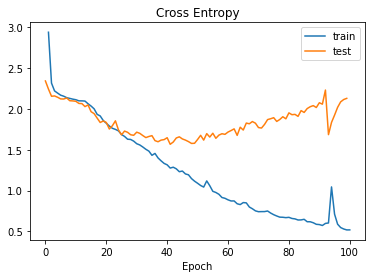

In [15]:
epochs_num = 100
u_net = UNet()
u_net.cuda()
optimizer = optim.Adam(u_net.parameters(), lr=0.0001, weight_decay=1e-8)
loss_function = nn.CrossEntropyLoss()
epochs_train_loss, epochs_test_loss = train_and_test(u_net, train_loader, test_loader, epochs_num, optimizer, loss_function)
print(epochs_train_loss)
print(epochs_test_loss)
plot_losses(epochs_train_loss, epochs_test_loss, epochs_num, "Cross Entropy")
torch.save(u_net, '/content/drive/MyDrive/weights.pt')

## Load Trained model

In [ ]:
u_net = torch.load('/content/drive/MyDrive/weights.pt')
u_net

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv11): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv13): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv15): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv16): Conv2d(128, 128, kernel_size=(3, 

## Predict image with traines model

In [41]:
def predict(model, data_set):
  with torch.no_grad():
    for features, targets in data_set:
      features, targets = features.cuda(), targets.cuda()
      output = model(features.float())
      prediction = output.argmax(1)
      return prediction, features

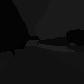

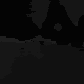

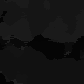

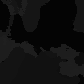

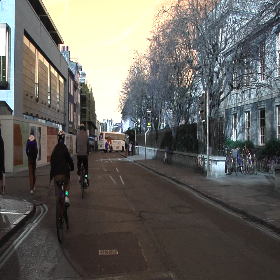

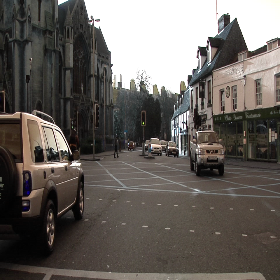

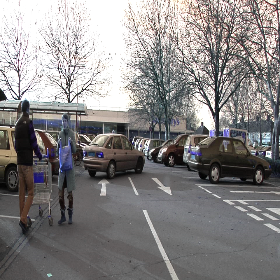

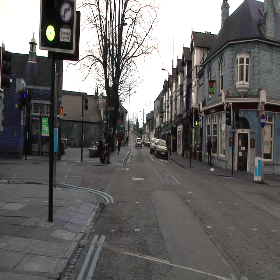

In [44]:
predictions, inputs = predict(u_net, test_loader)
for pred in predictions:
  cv2_imshow(pred.cpu().detach().numpy())
for inp in inputs:
  inp = inp.cpu().detach().numpy()
  cv2_imshow(inp.reshape((280, 280, 3)))

### Image playground

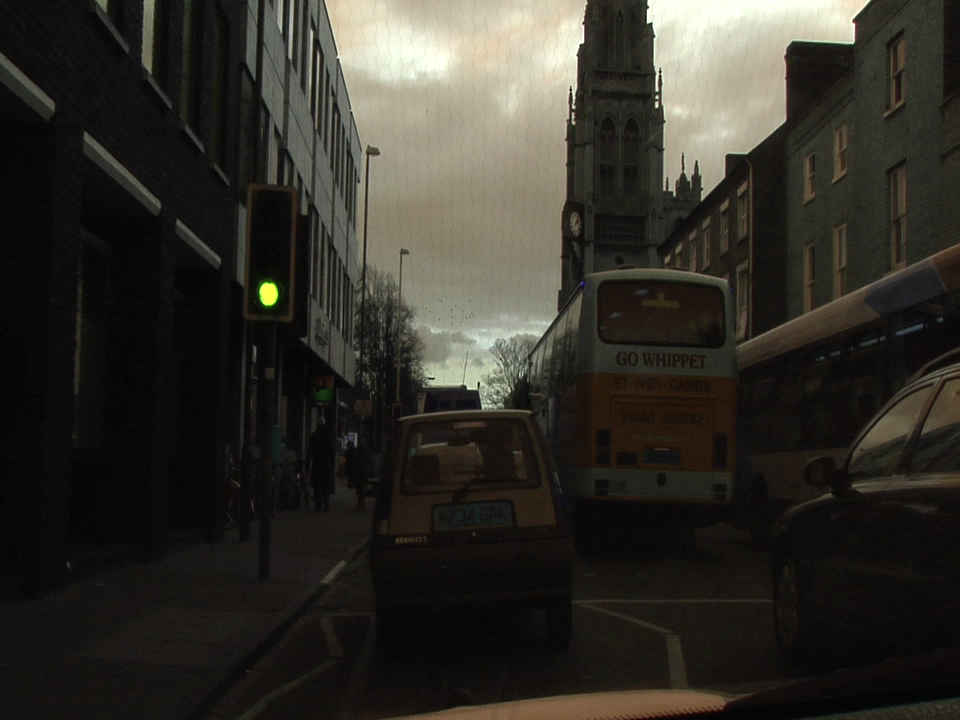

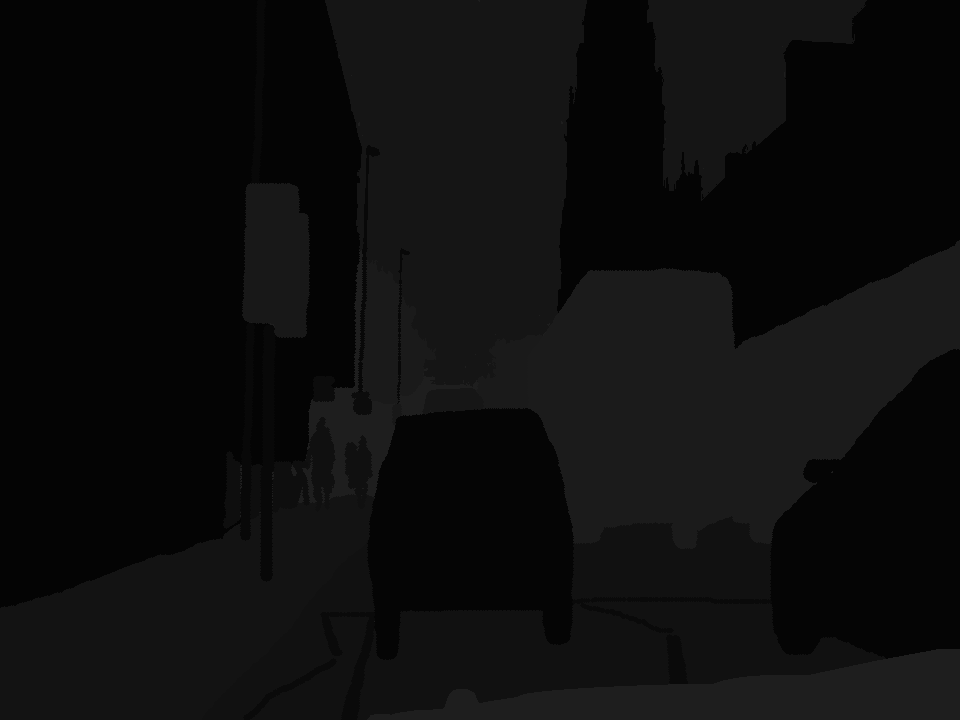

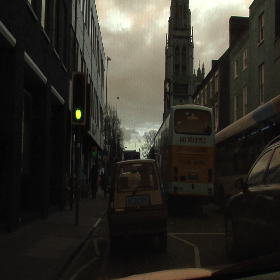

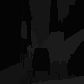

In [18]:
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/camvid/images/0001TP_006690.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = cv2.imread('/content/camvid/labels/0001TP_006690.png')
cv2_imshow(image)
cv2_imshow(label)
# image_height, image_width, image_dim = image.shape
# image = image.reshape(image_dim, image_height, image_width)
image = cv2.resize(image, (280, 280))
cv2_imshow(image)
label = cv2.resize(label, (84, 84))
cv2_imshow(label)

## Train to best epoch

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


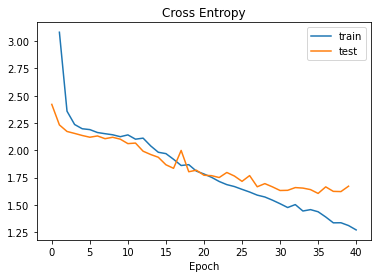

In [45]:
epochs_num = 40
u_net2 = UNet()
u_net2.cuda()
optimizer2 = optim.Adam(u_net2.parameters(), lr=0.0001, weight_decay=1e-8)
loss_function2 = nn.CrossEntropyLoss()
epochs_train_loss2, epochs_test_loss2 = train_and_test(u_net2, train_loader, test_loader, epochs_num, optimizer2, loss_function2)
plot_losses(epochs_train_loss2, epochs_test_loss2, epochs_num, "Cross Entropy")
torch.save(u_net2, '/content/drive/MyDrive/best_weights.pt')

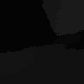

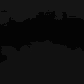

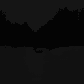

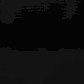

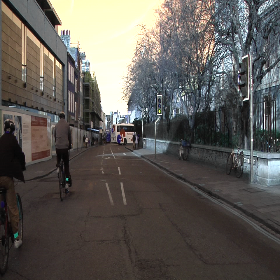

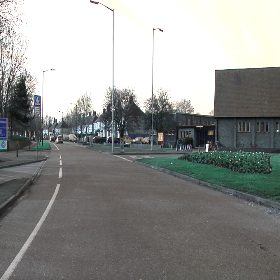

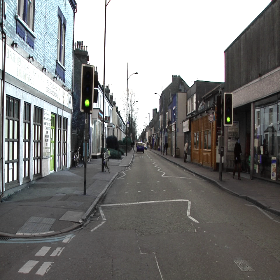

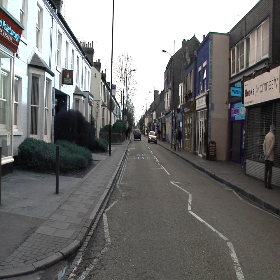

In [46]:
predictions, inputs = predict(u_net2, test_loader)
for pred in predictions:
  cv2_imshow(pred.cpu().detach().numpy())
for inp in inputs:
  inp = inp.cpu().detach().numpy()
  cv2_imshow(inp.reshape((280, 280, 3)))